Agregamos las librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Esto es por una cuestion estetica

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)
sns.set(style='whitegrid', palette='muted')

Carga de datos

In [3]:
clientes = pd.read_excel('clientes.xlsx')
productos = pd.read_excel('CopiaDeProductos.xlsx')
detalle = pd.read_excel('detalle_ventas.xlsx')
ventas = pd.read_excel('ventas.xlsx')

print("Clientes:", clientes.shape)
print("Productos:", productos.shape)
print("Detalle Ventas:", detalle.shape)
print("Ventas:", ventas.shape)

Clientes: (100, 5)
Productos: (100, 4)
Detalle Ventas: (343, 6)
Ventas: (120, 6)


Vista previa

In [4]:
print("Clientes")
display(clientes.head())
print("Productos")
display(productos.head())
print("Detalle de Ventas")
display(detalle.head())
print("Ventas")
display(ventas.head())


Clientes


,id_cliente,nombre_cliente,email,ciudad,fecha_alta
0,1,Mariana Lopez,mariana.lopez@mail.com,Carlos Paz,2023-01-01
1,2,Nicolas Rojas,nicolas.rojas@mail.com,Carlos Paz,2023-01-02
2,3,Hernan Martinez,hernan.martinez@mail.com,Rio Cuarto,2023-01-03
3,4,Uma Martinez,uma.martinez@mail.com,Carlos Paz,2023-01-04
4,5,Agustina Flores,agustina.flores@mail.com,Cordoba,2023-01-05


Productos


,id_producto,nombre_producto,categoria,precio_unitario
0,1,Coca Cola 1.5L,Alimentos,2347
1,2,Pepsi 1.5L,Alimentos,4973
2,3,Sprite 1.5L,Alimentos,4964
3,4,Fanta Naranja 1.5L,Alimentos,2033
4,5,Agua Mineral 500ml,Alimentos,4777


Detalle de Ventas


,id_venta,id_producto,nombre_producto,cantidad,precio_unitario,importe
0,1,90,Toallas Húmedas x50,1,2902,2902
1,2,82,Aceitunas Negras 200g,5,2394,11970
2,2,39,Helado Vainilla 1L,5,469,2345
3,2,70,Fernet 750ml,2,4061,8122
4,2,22,Medialunas de Manteca,1,2069,2069


Ventas


,id_venta,fecha,id_cliente,nombre_cliente,email,medio_pago
0,1,2024-06-19,62,Guadalupe Romero,guadalupe.romero@mail.com,tarjeta
1,2,2024-03-17,49,Olivia Gomez,olivia.gomez@mail.com,qr
2,3,2024-01-13,20,Tomas Acosta,tomas.acosta@mail.com,tarjeta
3,4,2024-02-27,36,Martina Molina,martina.molina@mail.com,transferencia
4,5,2024-06-11,56,Bruno Diaz,bruno.diaz@mail.com,tarjeta


# codificar variables categóricas

In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in ['nombre_producto_venta', 'ciudad', 'medio_pago']:
    df[col + '_num'] = LabelEncoder().fit_transform(df[col])


*Integración de datos*: unimos todo en un solo DataFrame maestro

In [5]:
df = detalle.merge(productos, on='id_producto', how='left', suffixes=('_venta', '_producto'))
df = df.merge(ventas[['id_venta', 'fecha', 'id_cliente', 'medio_pago']], on='id_venta', how='left')
df = df.merge(clientes[['id_cliente', 'ciudad']], on='id_cliente', how='left')

df['fecha'] = pd.to_datetime(df['fecha'])

Visualizamos sus columnas

In [6]:
print(df.columns)

Index(['id_venta', 'id_producto', 'nombre_producto_venta', 'cantidad',
       'precio_unitario_venta', 'importe', 'nombre_producto_producto',
       'categoria', 'precio_unitario_producto', 'fecha', 'id_cliente',
       'medio_pago', 'ciudad'],
      dtype='object')


calcular la rotación

In [ ]:
df = df.sort_values(by=['nombre_producto_venta', 'fecha_venta'])

df['rotacion_dias'] = df.groupby('nombre_producto_venta')['fecha_venta'].diff().dt.days


Promedio

In [ ]:
rotacion_promedio = df.groupby('nombre_producto_venta')['rotacion_dias'].mean().reset_index()


Sacar el mes de la tabla de ventas

In [ ]:
df['mes'] = df['fecha_venta'].dt.to_period('M')
importe_mensual = df.groupby(['mes'])['importe'].sum().reset_index()


Después podés calcular la variación porcentual mes a mes (la “caída”)

In [ ]:
importe_mensual['variacion_%'] = importe_mensual['importe'].pct_change() * 100


analizar relación entre rotación y caída

In [ ]:
df_analisis = df.merge(rotacion_promedio, on='nombre_producto_venta', how='left')


Graficos de la relacion entre rotacion y importe

In [ ]:

sns.scatterplot(data=df_analisis, x='rotacion_dias', y='importe')
plt.title('Relación entre rotación y monto vendido')
plt.show()

(Posible conclusion)“Los productos con baja rotación (más días entre ventas) están asociados a una disminución del importe mensual percibido.”

# Estadisticas

In [7]:
print("\n--- Estadísticas Generales ---")
display(df[['cantidad', 'importe', 'precio_unitario_venta']].describe())


--- Estadísticas Generales ---


,cantidad,importe,precio_unitario_venta
count,343.00,343.00,343.00
mean,2.96,"7,730.08","2,654.50"
std,1.37,"5,265.54","1,308.69"
min,1.00,272.00,272.00
25%,2.00,"3,489.00","1,618.50"
50%,3.00,"6,702.00","2,512.00"
75%,4.00,"10,231.50","3,876.00"
max,5.00,"24,865.00","4,982.00"


- Cantidad vendida promedio:

En promedio se venden casi 3 unidades por producto, con un máximo de 5.
Esto indica una demanda moderada y bastante pareja (la dispersión no es muy grande).

- Importe total promedio:

El importe medio por producto ronda los $7.730, pero con una desviación alta ($5.265).
Esto sugiere que hay mucha variabilidad entre productos, algunos con ventas pequeñas y otros con importes altos.

- Precio unitario:

El precio promedio es de $2.654, y varía entre $272 y $4.982.
Esto muestra una amplitud de precios considerable, lo cual puede explicar la diferencia de ingresos entre categorías.

- Distribución general:

El 25% de los productos factura menos de $3.489, mientras que el 25% superior supera los $10.231, lo que refuerza la idea de una distribución sesgada hacia algunos productos muy rentables.

- Ventas totales por productos

        nombre_producto_venta  cantidad  importe
5              Alfajor Triple         2     2002
90                Vodka 700ml         4     2032
20   Chocolate con Leche 100g         2     2510
62        Pan Lactal Integral        11     2992
84       Té Negro 20 saquitos         7     3990
13  Caldo Concentrado Verdura         4     4012
87   Vinagre de Alcohol 500ml         4     4780
25   Detergente Líquido 750ml         2     5164
31      Fideos Spaghetti 500g         9     6705
83                 Turrón 50g        15     7545


C:\Users\srceb\AppData\Local\Temp\ipykernel_21276\3150469111.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


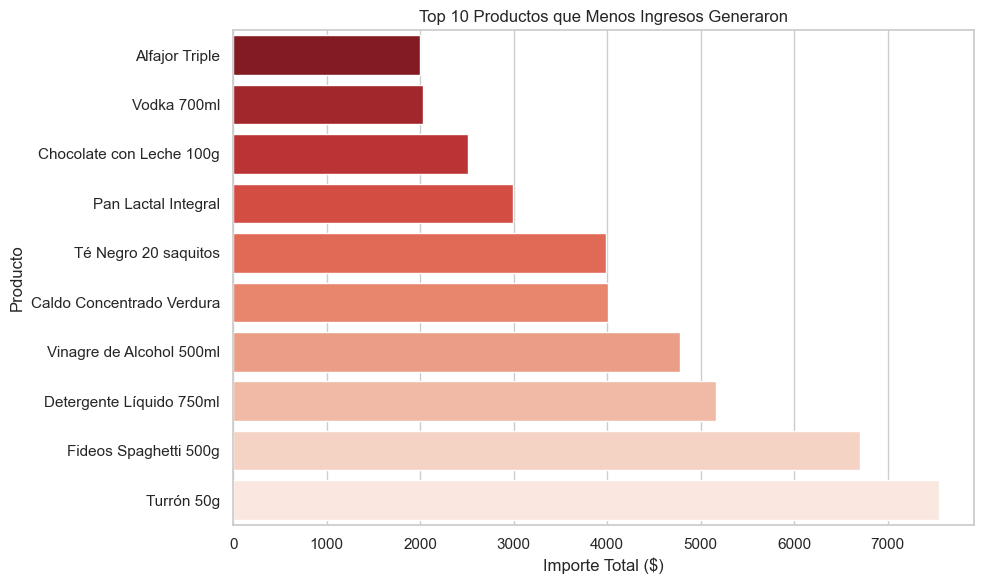

In [8]:
# Agrupar ventas por producto
# Agrupar por producto y sumar cantidad e importe total
ventas_por_producto = (
    df.groupby('nombre_producto_venta')[['cantidad', 'importe']]
      .sum()
      .reset_index()
      .sort_values(by='importe', ascending=True)
)

# Tomamos los 10 que menos plata generaron
menos_rentables = ventas_por_producto.head(10)
print(menos_rentables)

# --- Gráfico: Productos que menos facturan ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=menos_rentables,
    x='importe',
    y='nombre_producto_venta',
    palette='Reds_r'
)
plt.title('Top 10 Productos que Menos Ingresos Generaron')
plt.xlabel('Importe Total ($)')
plt.ylabel('Producto')
plt.tight_layout()
plt.show()





- Top 10 menos vendidos

In [9]:
top10 = ventas_por_producto.head(10)
display(top10)

,nombre_producto_venta,cantidad,importe
5,Alfajor Triple,2,2002
90,Vodka 700ml,4,2032
20,Chocolate con Leche 100g,2,2510
62,Pan Lactal Integral,11,2992
84,Té Negro 20 saquitos,7,3990
13,Caldo Concentrado Verdura,4,4012
87,Vinagre de Alcohol 500ml,4,4780
25,Detergente Líquido 750ml,2,5164
31,Fideos Spaghetti 500g,9,6705
83,Turrón 50g,15,7545


- Productos menos vendidos

In [10]:
bottom10 = ventas_por_producto.tail(10)
display(bottom10)

,nombre_producto_venta,cantidad,importe
37,Hamburguesas Congeladas x4,24,58080
88,Vino Blanco 750ml,22,59048
14,Caramelos Masticables,14,66528
18,Chicle Menta,19,68628
28,Energética Nitro 500ml,17,71706
93,Yerba Mate Suave 1kg,20,77560
73,Ron 700ml,21,81396
67,Pizza Congelada Muzzarella,20,85720
71,Queso Rallado 150g,26,89544
24,Desodorante Aerosol,20,93800


- Clasificación de productos según nivel de ventas

C:\Users\srceb\AppData\Local\Temp\ipykernel_21276\547351935.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='categoria_venta', data=ventas_por_producto, palette=['#2b83ba','#abdda4','#fdae61'])


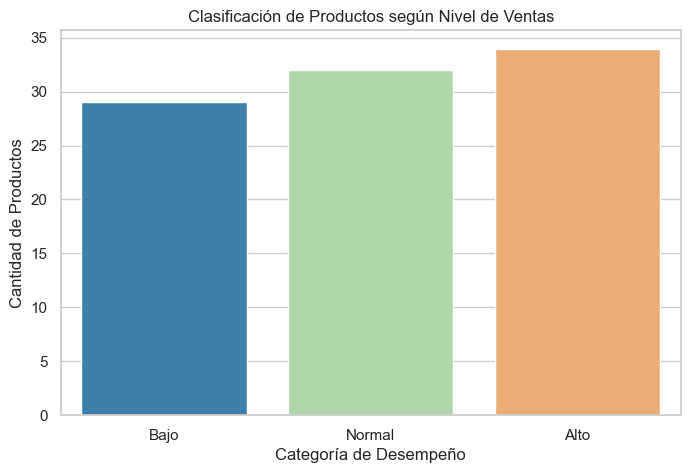

In [11]:
q1 = ventas_por_producto['cantidad'].quantile(0.33)
q2 = ventas_por_producto['cantidad'].quantile(0.66)
def clasificar_producto(cant):
    if cant < q1:
        return 'Bajo'
    elif cant < q2:
        return 'Normal'
    else:
        return 'Alto'

ventas_por_producto['categoria_venta'] = ventas_por_producto['cantidad'].apply(clasificar_producto)

plt.figure(figsize=(8,5))
sns.countplot(x='categoria_venta', data=ventas_por_producto, palette=['#2b83ba','#abdda4','#fdae61'])
plt.title('Clasificación de Productos según Nivel de Ventas')
plt.xlabel('Categoría de Desempeño')
plt.ylabel('Cantidad de Productos')
plt.show()


Distribucion de ventas(importe)

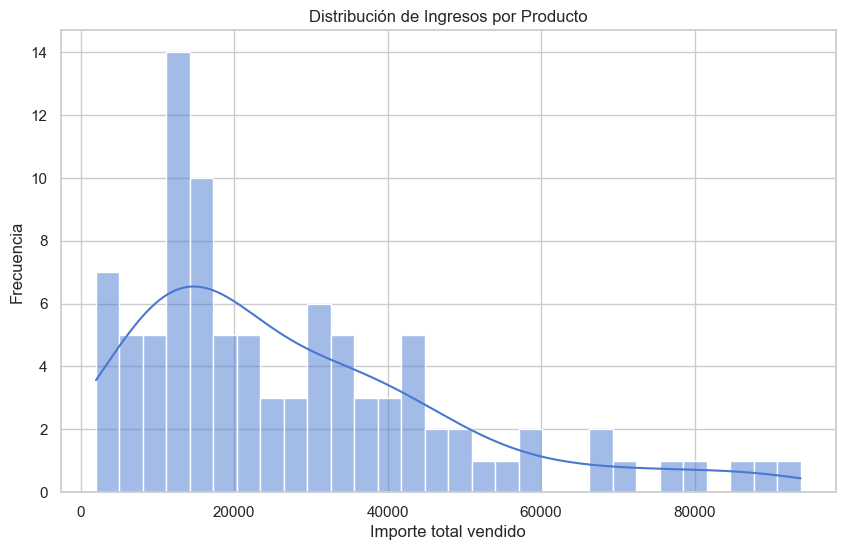

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(ventas_por_producto['importe'], bins=30, kde=True)
plt.title('Distribución de Ingresos por Producto')
plt.xlabel('Importe total vendido')
plt.ylabel('Frecuencia')
plt.show()


Distribución sesgada hacia la derecha (sesgo positivo):
La mayoría de los productos se concentran en ingresos bajos (entre 0 y 30.000 aproximadamente), y solo unos pocos alcanzan valores altos.
→ Esto indica que la facturación está concentrada en pocos productos, lo que es típico en negocios con un mix amplio.

Alta frecuencia de productos de bajo rendimiento:
El pico del histograma (las barras más altas) representa productos con bajo ingreso, lo que sugiere que hay mucha oferta poco rentable o de baja rotación.

Pocos productos estrella:
Los valores en la cola derecha (por encima de 60.000 o 80.000) son pocos, pero aportan una gran parte del total de ingresos.
→ Acá están los productos “estrella” que conviene mantener y potenciar.

Oportunidad de optimización:
La forma de la distribución sugiere que el negocio podría mejorar su rentabilidad general reduciendo el peso de los productos con ventas marginales o aplicando estrategias de rotación.

Correlación entre cantidad e importe

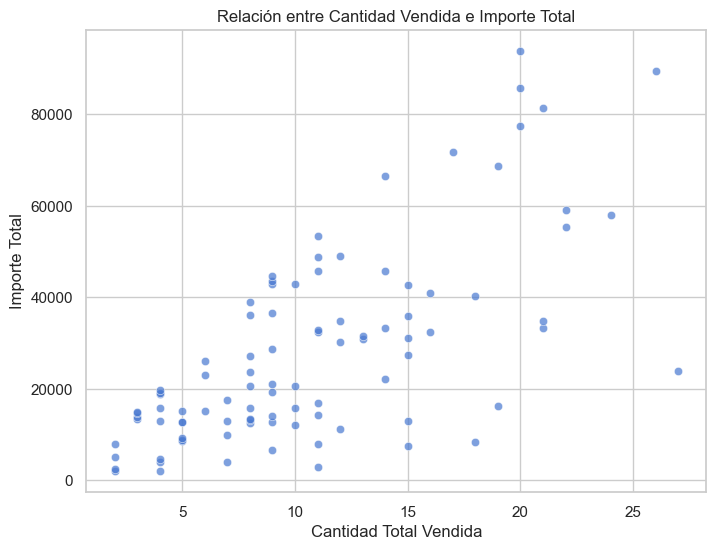

In [13]:

plt.figure(figsize=(8,6))
sns.scatterplot(data=ventas_por_producto, x='cantidad', y='importe', alpha=0.7)
plt.title('Relación entre Cantidad Vendida e Importe Total')
plt.xlabel('Cantidad Total Vendida')
plt.ylabel('Importe Total')
plt.show()

- Relación positiva evidente:
En general, los puntos muestran una tendencia ascendente, lo que indica que a mayor cantidad vendida, mayor ingreso total. Es lo esperable y valida que los datos estén coherentes.

- Dispersión moderada:
No todos los productos siguen la línea perfecta —hay productos con pocas unidades vendidas que igual generan ingresos altos, lo que sugiere precios unitarios elevados o márgenes altos.
→ Ejemplo: productos premium o de nicho.

- Productos poco rentables:
Los puntos más abajo y hacia la izquierda (baja cantidad y bajo importe) representan productos con bajo rendimiento, los que se podría considerar como poco rentables.

- Posibles oportunidades:
Algunos puntos más altos pero con baja cantidad indican artículos que podrían generar más ingresos si se vendieran más unidades

Outliders

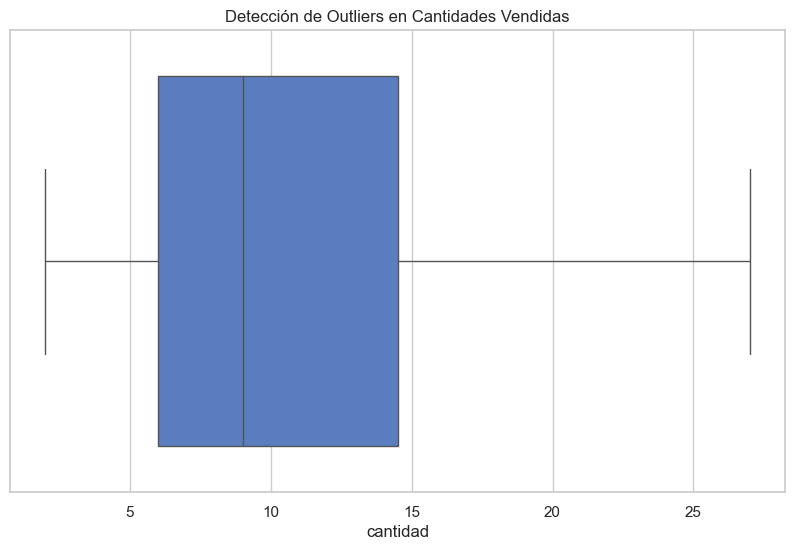

Cantidad de productos considerados outliers: 0


In [14]:
def detectar_outliers(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    limite_inf = q1 - 1.5 * iqr
    limite_sup = q3 + 1.5 * iqr
    return ((col < limite_inf) | (col > limite_sup))

ventas_por_producto['outlier'] = detectar_outliers(ventas_por_producto['cantidad'])
outliers = ventas_por_producto[ventas_por_producto['outlier'] == True]

plt.figure(figsize=(10,6))
sns.boxplot(x=ventas_por_producto['cantidad'])
plt.title('Detección de Outliers en Cantidades Vendidas')
plt.show()

print("Cantidad de productos considerados outliers:", outliers.shape[0])


El rectángulo representa el rango intercuartílico (del 25% al 75% de los datos).

La línea dentro de la caja es la mediana (el valor central de las ventas).

Las "bigotes" (líneas que salen de la caja) muestran el rango de valores considerados normales.

En este caso no hay puntos aislados fuera de los bigotes, por lo que no se observan outliers significativos en las cantidades vendidas.

La mediana está cerca del centro del rango, lo que indica una distribución relativamente simétrica en los valores de venta.

# Evolucion de ventas en el tiempo

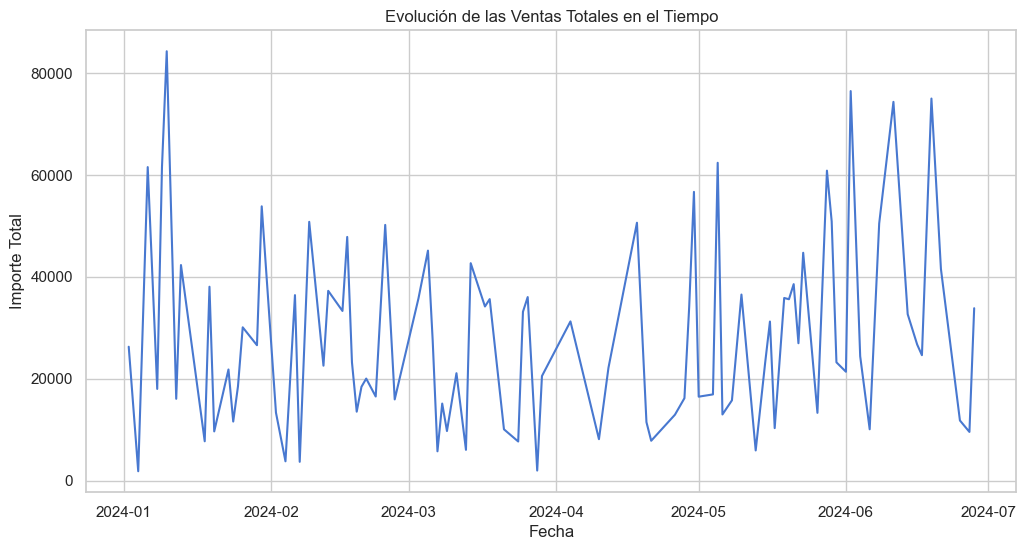

In [15]:
ventas_tiempo = (
    df.groupby('fecha')['importe']
    .sum()
    .reset_index()
    .sort_values('fecha')
)

plt.figure(figsize=(12,6))
sns.lineplot(data=ventas_tiempo, x='fecha', y='importe')
plt.title('Evolución de las Ventas Totales en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Importe Total')
plt.show()


- *Alta variabilidad de las ventas*:
Se observa que el importe total fluctúa bastante día a día o semana a semana. Esto puede deberse a promociones, fechas puntuales de alta demanda o diferencias en los canales de venta.

- *Tendencia general levemente creciente hacia mitad de año*:
Aunque hay muchos picos y valles, se nota una recuperación progresiva a partir de abril, con varios puntos de ventas altas en mayo y junio.
→ Esto podría indicar una mejor performance comercial en el segundo trimestre.

- *Picos de ventas destacados*:
Algunos picos (como el de enero o los de mayo-junio) pueden corresponder a eventos o campañas específicas. Sería útil contrastar esas fechas con promociones, lanzamientos o fechas especiales.

- *Faltan períodos de ventas bajas o vacíos*:
Los valles del gráfico (ventas cercanas a cero) podrían reflejar fines de semana, feriados o períodos sin actividad, lo cual puede servir para planificar estrategias para mantener la regularidad.

Analisis de categoria por producto

C:\Users\srceb\AppData\Local\Temp\ipykernel_21276\3936050513.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ventas_categoria.index, y=ventas_categoria.values, palette='viridis')


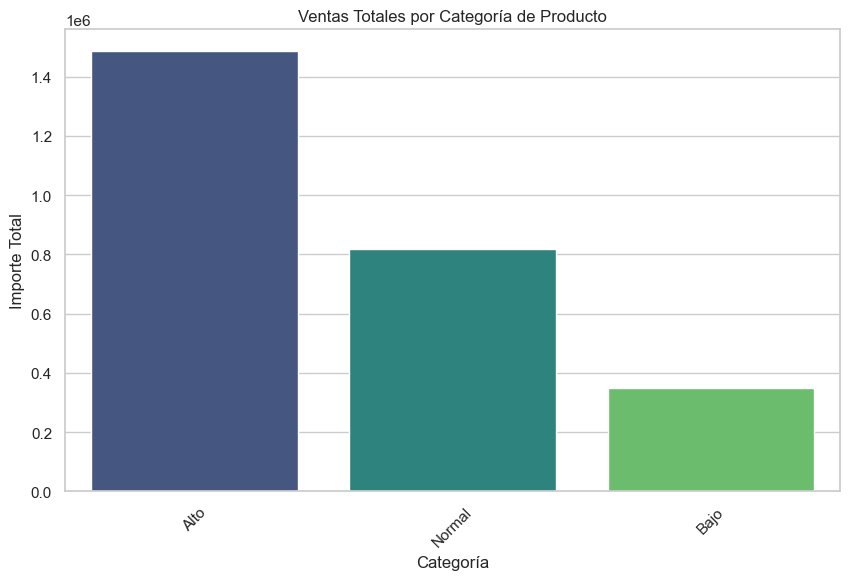

In [16]:
ventas_categoria = (
    ventas_por_producto.groupby('categoria_venta')['importe']
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(x=ventas_categoria.index, y=ventas_categoria.values, palette='viridis')
plt.title('Ventas Totales por Categoría de Producto')
plt.xlabel('Categoría')
plt.ylabel('Importe Total')
plt.xticks(rotation=45)
plt.show()


- Los productos de categoría alta son los que más ingresos generan, representando la mayor parte de las ventas totales.
 
- Los productos de categoría media muestran un rendimiento intermedio, aportando de forma constante pero sin destacar.

- Los productos de categoría baja tienen una contribución marginal a las ventas, lo que sugiere baja demanda o márgenes reducidos.

**Conclusiones finales del análisis**

- La rentabilidad del negocio depende principalmente de los productos de categoría alta, que concentran gran parte de los ingresos.

- Los productos de categoría baja podrían requerir una revisión estratégica: promociones, reposicionamiento o incluso reemplazo.

- Los productos de categoría media funcionan como un segmento de equilibrio, manteniendo estabilidad en las ventas.

- En conjunto, los datos muestran una cartera de productos concentrada, donde pocos ítems generan la mayor parte de la facturación